In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils
import time
from scipy.optimize import minimize
from tensorflow.contrib.opt.python.training import external_optimizer

%matplotlib inline

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 25
i_print = 25

#0.5 - noise , 0.5 + noise
noise_weight = 0.4

device = '/gpu:0'
show = True

#layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
style_weight = [0.2, 0.5, 0.9, 1.0, 1.0]
TV_weight = [0, 0, 0, 0, 0]


# Plots loss over time
loss_graph = [] 
optimizer_plot = True

# Optimizer: GD = Gradient Descent, Ad = Adam, L = L-BFGS-B
opt = 'Ad'

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    if M < N:
        return tf.matmul(Ft,tf.transpose(Ft))
    else:
        return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def main_loss_function(x):
    return

In [5]:
def create_noise_image(width, height):
    image = np.random.uniform(0.5 - noise_weight,0.5 + noise_weight, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [6]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [7]:
def get_layers(image, scope):      
    #vgg
    vgg = vgg19.Vgg19()
    
    with tf.name_scope(scope):
        vgg.build(image)

    layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    #layers = [vgg.conv1_1]
    
    return layers

In [8]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        #gram_losses.append(tf.nn.l2_loss(target_gram))
        #gram_losses.append(tf.nn.l2_loss(input_gram))
        
        #get losses
        gram_losses.append(w * tf.log(tf.reduce_sum(tf.square(target_gram - input_gram)) / size ))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_losses

In [9]:
def get_loss(target_layers, input_layers):
    loss = 0
    losses = []
    
    #gram loss
    gram_loss = get_gram_loss(target_layers, input_layers) 
    
    #get histogram matrices
    
    
    
    # Total variation loss
    total_variation_loss = get_TV_loss(target_layers, input_layers)
    
    return tf.log(gram_loss + total_variation_loss)

In [10]:
def get_TV_loss(target_layers, input_layers):

    #go through layers
    total_variation_loss = 0
    for tl, w in zip(target_layers, TV_weight):
        
        #get total variation
        total_variation_loss += w * tf.image.total_variation(tl)
    
    return total_variation_loss

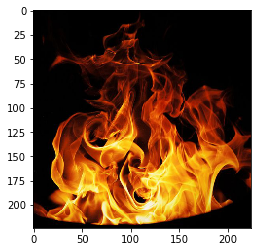

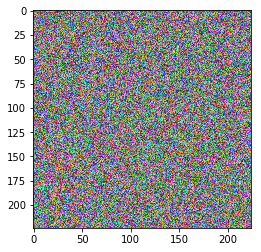

In [11]:
with tf.device(device):
    sess = tf.InteractiveSession()
        
    #placeholders
    input_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    
    #load style image
    input_img = get_image("./test_data/fire.jpg")
    #create target image
    target_img = (create_noise_image(224, 224))
        
    #fill feed dictionary
    feed = {input_image: input_img}
                 
    #create variables                 
    target = tf.Variable(target_img, tf.float32)

    


In [12]:
    #input vgg
    style_layers = get_layers(input_image, "style")
    #target vgg
    target_layers = get_layers(target, "target")
    
    #get losses
    loss = tf.reduce_sum(get_loss(target_layers, style_layers))

/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s


15.3688
[ 1.87310946  3.01979804  3.48449278  3.57015777  3.42124176]


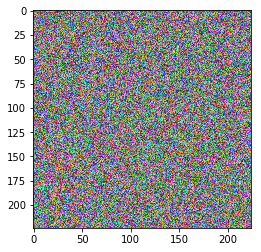

In [13]:
    learning_rate = 0.01
    #handlers
    if (opt == 'GD'): # Choose a better one. 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        minimize = optimizer.minimize(loss)
    elif (opt == 'Ad'):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        minimize = optimizer.minimize(loss)
    elif (opt == 'L'): #TODO: L-BFGS-B Optimizer not working
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss,method='L-BFGS-B',options={'maxiter': i_max})

        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            print("minimizing")
            optimizer.minimize(session)
            print("minimized")
        
    else:
        pass
    
    #init
    sess.run(tf.global_variables_initializer())
    
    
    print(sess.run(loss, feed_dict = feed))
    print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))
    
    #show image
    if(show == True):
        plt.imshow(sess.run(tf.reshape(target,(224,224,3)), feed_dict = feed))
        plt.show()
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
15.1948
[ 1.80089152  2.98233128  3.43456101  3.55924964  3.41780305]


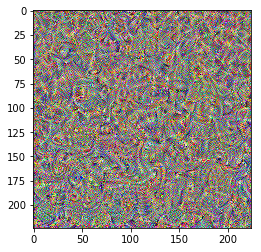

Task took 53.98 seconds, 2.16 seconds/iteration


In [14]:
    if (optimizer_plot == True):
        start_time = time.time()
    
    
    for i in range(i_max):
        
        #optimize step
        sess.run(minimize, feed_dict = feed)
        tf.minimum(tf.maximum(target,1),0.0)
        
        if (optimizer_plot == True):
            wall_time = time.time() - start_time
        
        
        print(i, end = '')
        print(' ', end = '')
        
        if((i+1) % i_print == 0):
            
            #print loss
            #print(sess.run(target_layers, feed_dict = feed))
            print('')
            loss_compute = sess.run(loss, feed_dict = feed)
            print(loss_compute)
            # print(sess.run(loss, feed_dict = feed))
            print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))
        
            if (optimizer_plot == True):
                loss_graph.append((wall_time, loss_compute))
            
            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(target,(224,224,3)), feed_dict = feed))
                plt.show()

    print ('Task took {:.2f} seconds, {:.2f} seconds/iteration'.format(wall_time, wall_time/i_max))
